# EEEN30131 Power System Analysis: Week 04 - Frequency regulation

***&copy; 2024 Martínez Ceseña — University of Manchester, UK***

This notebook provides several examples covering frequency regulation and generation control, including general `python` code which can be used to solve the examples and create new ones.

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as such activities will better prepare you for the exams.

## List of contents

- [Primary frequency regulation](#Primary-frequency-regulation)
  - [Frequency response](#Frequency-response)
  - [Area frequency response](#Area-frequency-response)
- [Control models](#Control-models)
  - [Generator model](#Generator-model)
  - [Generator and load model](#Generator-and-load-model)
  - [Generator, load and prime mover](#Generator,-load-and-prime-mover)
  - [Generator, load, prime mover and droop model](#Generator,-load,-prime-mover-and-droop-model)
  - [Coding the control model](#Coding-the-control-model)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30131 Week 4 - Frequency regulation 
- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

If this data notebook is being used in Jupyter lite, the folders where the python code that supports this notebook are stored, have to be enabled.

In [1]:
from pathlib import Path
if Path.cwd().drive == '':
    a_dir = Path("dir")
    a_dir.mkdir(exist_ok=True)

Also, the following libraries are required by the notebook:

In [2]:
try:
    import mplcursors as widgets
except:
    import micropip
    await micropip.install('mplcursors')
    import mplcursors
import numpy
import matplotlib.pyplot as plt
import control

## Primary frequency regulation

### Frequency response

There are two main components of the power system that react to frequency variationd and provide frequency response, namely the synchronous generators and the loads. The equations used to model the primary and secondary frequency response of these componets are provided below:

$$
\Delta P_m = \Delta P_{ref} - \frac{1}{R} \Delta f
$$

$$
\Delta P_e = \Delta P_L + D \Delta \omega
$$

To illustrate the way the loads and the outputs of the synchronous generators change in response to frequency variations ($\Delta f$) it is convenient to  plot the equations above. For that purspose, the following method is created:

In [3]:
def plot_ΔPm(Δf_check, ΔPref_List, R_List, ΔPL_List, D_List, ΔPm_List,
             Δf_List):

    plt.figure(figsize=(7, 3))

    # Adding generators
    No_Gens = len(ΔPref_List)
    for x in range(No_Gens):
        ΔPref = ΔPref_List[x]
        R = R_List[x]
        lbl = 'G' + str(x+1) + ', ΔPref=' + str(ΔPref) + ', R=' + str(R)
        ΔPm = []
        for Δf in Δf_List:
            ΔPm.append(ΔPref - 1/R*Δf)
        plt.plot(ΔPm, Δf_List, label=lbl)
        print('ΔPm%d: %10.4f (pu)' % (x+1, ΔPref-1/R*Δf_check))

    # Adding loads
    No_Loads = len(ΔPL_List)
    for x in range(No_Loads):
        ΔPL = ΔPL_List[x]
        D = D_List[x]
        lbl = 'L' + str(x+1) + ', ΔPL=' + str(ΔPL) + ', D=' + str(D)
        ΔPe = []
        for Δf in Δf_List:
            ΔPe.append(ΔPL + D*Δf)
        plt.plot(ΔPe, Δf_List, label=lbl)
        print('ΔPe%d: %10.4f (pu)' % (x+1, ΔPL + D*Δf_check))

    plt.plot(ΔPm_List, [Δf_check, Δf_check], linestyle='dashed',
             label='Pimary response')
    plt.xlim(ΔPm_List)
    plt.grid()
    plt.legend()
    plt.ylabel('Δf [pu]')
    if No_Gens > 0:
        if No_Loads > 0:
            plt.xlabel('ΔPm and ΔPe [pu]')
        else:
            plt.xlabel('ΔPm [pu]')
    else:
        plt.xlabel('ΔPe [pu]')
    plt.show()

    mplcursors.cursor()

Let us use a small example to illustrate the frequecy response of generators and loads.

ΔPm1:     0.0500 (pu)
ΔPe1:    -0.0030 (pu)


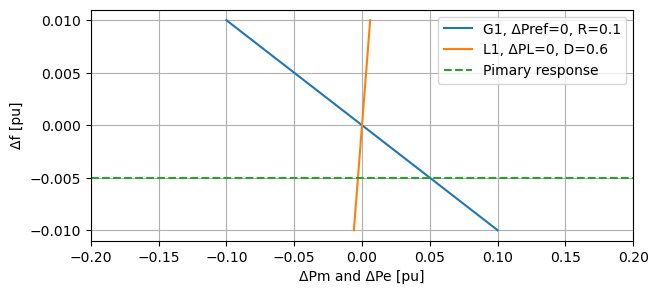

In [4]:
# Disturbance to check
Δf_check = -0.005  # Frequency variation

# Generator
ΔPref_List = [0]  # pu
R_List = [0.1]  # pu

# Load
ΔPL_List = [0]  # pu
D_List = [0.6]  # pu

# X and Y axes for the figure
Δf_List = [-0.01, 0.01]  # pu
ΔPm_List = [-0.2, 0.2]  # pu

# Plot figure
plot_ΔPm(Δf_check, ΔPref_List, R_List, ΔPL_List, D_List, ΔPm_List, Δf_List)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

### Area frequency response

Let us now develop a more complex example with multiple generators and loads.

In [5]:
# Characteristics of the disturbance
Dist = {
    'Area':1,
    'Magnitude': 300,  # Positive: Generation is higher than load
    'Flow': 100  # From area 1 to 2 by default
}

# Characteristics of the generators
Gen = [
    {'Area':1, 'Capacity': 4000, 'R':4, 'Units': '%', 'Output': 0, 'ΔPref':0},
    {'Area':2, 'Capacity': 2000, 'R':0.00125, 'Units': 'Hz/MW', 'Output': 0, 'ΔPref':0}
]

# Characteristics of the loads
Load = [
    {'D':0.6, 'Units': 'pu'},
    {'D':40, 'Units': 'MW/Hz'}
]

# Bases
Base = 4000
F = 50

This time, the information can be provided using different units, e.g., in the case of $R$ it can be expressed in %, pu or Hz/MW. Thus, we need a method to convert the data to pu.

In [6]:
def get_pu(Dist, Gen, Load, Base, F):
    import copy
    Disturbance = copy.deepcopy(Dist)
    Disturbance['Magnitude'] /= Base

    Generators = copy.deepcopy(Gen)
    xg = 0
    for gen in Generators:
        R = gen['R']
        if gen['Units'] == 'Hz/MW':
            R *= Base/F
        else:
            if gen['Units'] == '%':
                R /= 100

            if 'Base' in gen.keys():
                R *= Base/gen['Base']
            else:
                R *= Base/gen['Capacity']

        Generators[xg]['R'] = R
        Generators[xg]['Units'] = 'pu'
        Generators[xg]['Base'] = Base
        xg += 1

    Damping = copy.deepcopy(Load)
    xd = 0
    for d in Load:
        D = d['D']
        if d['Units'] == 'MW/Hz':
            D *= F/Base
        else:
            if d['Units'] == '%':
                D /= 100

            if 'Base' in d.keys():
                D *= d['Base']/Base
        Damping[xd]['D'] = D
        Damping[xd]['Base'] = Base
        Damping[xd]['Units'] = 'pu'
        xd += 1

    return Disturbance, Generators, Damping

print('A disturbance occurred in Area %d'%Dist['Area'])
if Dist['Magnitude'] > 0:
    txt = 'higher'
else:
    txt = 'lower'
print('As a result generation is suddenlly %s than demand by %.4f MW'
      %(txt, abs(Dist['Magnitude'])))
print()
    
Disturbance, Generators, Damping = get_pu(Dist, Gen, Load, Base, F)
print('Data in pu')
print('Disturbance: %.4f MW (%.4f pu)'%(Dist['Magnitude'], Disturbance['Magnitude']))
No_Generators = len(Generators)
for xg in range(No_Generators):
    gen = Generators[xg]

    print('G%d) Area%d, Capacity: %10.2f MW, R:%10.4f pu, Output:%10.2f MW'
          %(xg+1, gen['Area'], gen['Capacity'], gen['R'], gen['Output']))
No_Areas = len(Damping)
for xd in range(No_Areas):
    damp = Damping[xd]
    print('L%d) Area%d, D: %.4f pu'%(xd+1, xd+1, damp['D']))
print('*Assuming a %d MVA base'%Generators[0]['Base'])

A disturbance occurred in Area 1
As a result generation is suddenlly higher than demand by 300.0000 MW

Data in pu
Disturbance: 300.0000 MW (0.0750 pu)
G1) Area1, Capacity:    4000.00 MW, R:    0.0400 pu, Output:      0.00 MW
G2) Area2, Capacity:    2000.00 MW, R:    0.1000 pu, Output:      0.00 MW
L1) Area1, D: 0.6000 pu
L2) Area2, D: 0.5000 pu
*Assuming a 4000 MVA base


The data, in pu, allows us to calculate the frequency variation:

In [7]:
def get_Δw(Disturbance, Generators, Damping, F):
    Δw = 0
    for d in Damping:
        Δw += d['D']

    for gen in Generators:
        Δw += 1/gen['R']

    Dst = Disturbance['Magnitude']
    for gen in Generators:
        if 'ΔPref' in gen.keys():
            gen['Secondary'] = gen['ΔPref']*gen['Capacity']/gen['Base']
            Dst += gen['Secondary']
    Δw = Dst/Δw
    Δf = Δw*F
    Ff = F+Δf

    return Δw, Δf, Ff

Δw, Δf, Ff = get_Δw(Disturbance, Generators, Damping, F)
print('The frequency changed by %.4f pu (%.4f Hz), so the new freqency is %.4f Hz'%(Δw,Δf, Ff))

The frequency changed by 0.0021 pu (0.1039 Hz), so the new freqency is 50.1039 Hz


Afterwards, we can calculate the prymary (and secondary) frequency response of every generator and load.

In [8]:
print('           ∆Pm and D∆ω     Operation')
print('          (pu)       (MW)       (MW)')
xg = 0
Response = 0
for gen in Generators:
    if 'Output' in Gen[xg].keys():
        Opt = Gen[xg]['Output']
    else:
        Opt = 0

    pu = -Δw/gen['R']
    prim = Base*pu
    xg += 1
    if 'ΔPref' in gen.keys():
        sec = gen['Secondary']*Base
    else:
        sec = 0
    gen['Output'] = Opt+prim+sec
    Response += prim+sec
    print('G%d) %10.4f %10.4f %10.4f (%10.4f+%10.4f+%10.4f)'
          %(xg, pu, prim, gen['Output'], Opt, prim, sec))

xd = 0
for damp in Damping:
    xd += 1
    Response -= damp['D']*Δw*Base
    print('L%d) %10.4f %10.4f'%(xd, damp['D']*Δw, damp['D']*Δw*Base))
print('All:           %10.4f'%Response)

           ∆Pm and D∆ω     Operation
          (pu)       (MW)       (MW)
G1)    -0.0519  -207.7562  -207.7562 (    0.0000+ -207.7562+    0.0000)
G2)    -0.0208   -83.1025   -83.1025 (    0.0000+  -83.1025+    0.0000)
L1)     0.0012     4.9861
L2)     0.0010     4.1551
All:            -300.0000


[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

For convenience, we place all the code above in a single method.

In [9]:
def get_Primary_Response(Dist, Gen, Load, Base, F):
    print('A disturbance occurred in Area %d' % Dist['Area'])
    if Dist['Magnitude'] > 0:
        txt = 'higher'
    else:
        txt = 'lower'
    print('As a result generation is suddenlly %s than demand by %.4f MW'
          % (txt, abs(Dist['Magnitude'])))
    print()

    Disturbance, Generators, Damping = get_pu(Dist, Gen, Load, Base, F)
    print('Disturbance: %.4f MW (%.4f pu)' %
          (Dist['Magnitude'], Disturbance['Magnitude']))
    No_Generators = len(Generators)
    for xg in range(No_Generators):
        gen = Generators[xg]

        print('G%d) Area%d, Capacity: %10.2f MW, R:%10.4f pu, Output:%10.2f MW'
              % (xg+1, gen['Area'], gen['Capacity'], gen['R'], gen['Output']))
    No_Areas = len(Damping)
    for xd in range(No_Areas):
        damp = Damping[xd]
        print('L%d) Area%d, D: %.4f pu' % (xd+1, xd+1, damp['D']))
    print('*Assuming a %d MVA base\n' % Generators[0]['Base'])

    Δw, Δf, Ff = get_Δw(Disturbance, Generators, Damping, F)
    print('The frequency changed by ', end='')
    print('%.4f pu (%.4f Hz), so the new freqency is %.4f Hz' % (Δw, Δf, Ff))

    print('           ∆Pm and D∆ω     Operation')
    print('          (pu)       (MW)       (MW)')
    xg = 0
    Response = 0
    for gen in Generators:
        if 'Output' in Gen[xg].keys():
            Opt = Gen[xg]['Output']
        else:
            Opt = 0

        pu = -Δw/gen['R']
        prim = Base*pu
        xg += 1
        if 'ΔPref' in gen.keys():
            sec = gen['Secondary']*Base
        else:
            sec = 0
        gen['Output'] = Opt+prim+sec
        Response += prim+sec
        print('G%d) %10.4f %10.4f %10.4f (%10.4f+%10.4f+%10.4f)'
              % (xg, pu, prim, gen['Output'], Opt, prim, sec))

    xd = 0
    for damp in Damping:
        xd += 1
        Response -= damp['D']*Δw*Base
        print('L%d) %10.4f %10.4f' % (xd, damp['D']*Δw, damp['D']*Δw*Base))
    print('All:           %10.4f' % Response)

We can now simulate examples using the `get_Primary_Response` method as shown below:

In [10]:
# Characteristics of the disturbance
Dist = {
    'Area':1,
    'Magnitude': -200,  # Positive: Generation is higher than load
    'Flow': 0  # From area 1 to 2 by default
}

# Characteristics of the generators
Gen = [
    {'Area':1, 'Capacity': 1000, 'R':0.05, 'Units': 'pu', 'Output': 0, 'ΔPref':0},
    {'Area':2, 'Capacity': 750, 'R':0.05, 'Units': 'pu', 'Output': 0, 'ΔPref':0},
    {'Area':2, 'Capacity': 500, 'R':0.05, 'Units': 'pu', 'Output': 0, 'ΔPref':0}
]

# Characteristics of the loads
Load = []

# Bases
Base = 1000
F = 50

get_Primary_Response(Dist, Gen, Load, Base, F)

A disturbance occurred in Area 1
As a result generation is suddenlly lower than demand by 200.0000 MW

Disturbance: -200.0000 MW (-0.2000 pu)
G1) Area1, Capacity:    1000.00 MW, R:    0.0500 pu, Output:      0.00 MW
G2) Area2, Capacity:     750.00 MW, R:    0.0667 pu, Output:      0.00 MW
G3) Area2, Capacity:     500.00 MW, R:    0.1000 pu, Output:      0.00 MW
*Assuming a 1000 MVA base

The frequency changed by -0.0044 pu (-0.2222 Hz), so the new freqency is 49.7778 Hz
           ∆Pm and D∆ω     Operation
          (pu)       (MW)       (MW)
G1)     0.0889    88.8889    88.8889 (    0.0000+   88.8889+    0.0000)
G2)     0.0667    66.6667    66.6667 (    0.0000+   66.6667+    0.0000)
G3)     0.0444    44.4444    44.4444 (    0.0000+   44.4444+    0.0000)
All:             200.0000


[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

## Control models

This section provides the control models for generators, loads, prime movers and droop.

### Generator model

Let us begin with the simplified control model of a synchronous generator.

![Generator_Model_Base.png](Figures/Generator_Model_Base.png)

In [11]:
M = 10
Generator = control.tf([1], [M, 0])
print('Generator:')
Generator

Generator:


TransferFunction(array([1]), array([10,  0]))

We will simulate this generator for 10 seconds, considering a step function starting one second after the simulation begins.

In [12]:
T = 10  # Seconds for the simulation
Init = 1  # First second to simulate
t = numpy.linspace(0,T,1000)

For the sake of convenience, we will create methods to produce step functions and plot the results.

In [13]:
def get_step(t, Init, Val):
    Dt = []
    for x in t:
        if x < Init:
            Dt.append(0)
        else:
            Dt.append(Val)
    return Dt

def plot_control(y, t):
    plt.figure(figsize=(7, 3))
    plt.plot(t, y)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.grid()
    plt.show()

These methods can be used to plot the input signal:

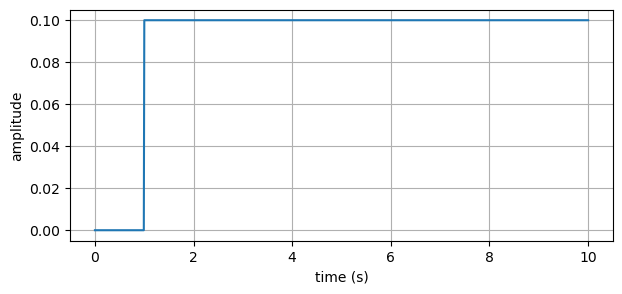

In [14]:
ΔPm_minus_ΔPe = get_step(t, Init, 0.1)
plot_control(ΔPm_minus_ΔPe, t)

As well as the outputs of the model:

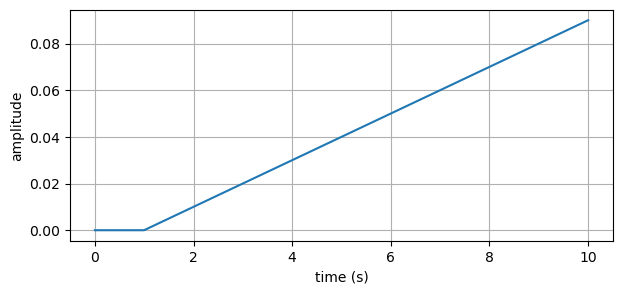

In [15]:
t, Δw = control.forced_response(Generator, t, ΔPm_minus_ΔPe)
plot_control(Δw, t)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

### Generator and load model

The model can be improved by adding the equations of the load and a feedback loop. 

![Generator_Load_model.png](Figures/Generator_Load_model.png)

In [16]:
D = 2
Load = control.tf(D, [1])
print('Load:')
Load

Load:


TransferFunction(array([2]), array([1]))

The combined generator model and feedback loop with the load can be modelled as follows:

In [17]:
Generator_Load = control.feedback(Generator, Load)
print('Generator + Load')
Generator_Load

Generator + Load


TransferFunction(array([1]), array([10,  2]))

The output of the model now changes to:

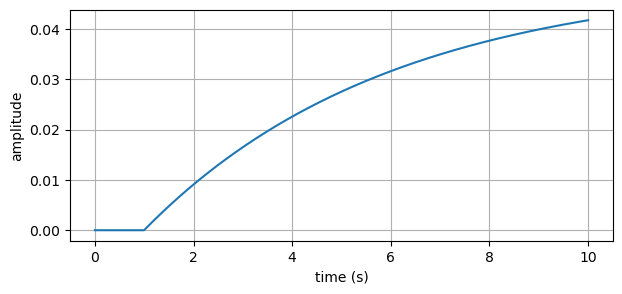

In [18]:
t, Δw = control.forced_response(Generator_Load, t, ΔPm_minus_ΔPe)
plot_control(Δw, t)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

### Generator, load and prime mover

The model can be further improved by including the equations of the prime mover.

![Generator_Load_PM_model.png](Figures/Generator_Load_PM_model.png)

In [19]:
Tch = 0.3
PM = control.tf(1, [Tch, 1])
print('Prime mover:')
PM

Prime mover:


TransferFunction(array([1]), array([0.3, 1. ]))

The model now includes input signals for $\Delta P_L$ and $\Delta P_{valve}$: 

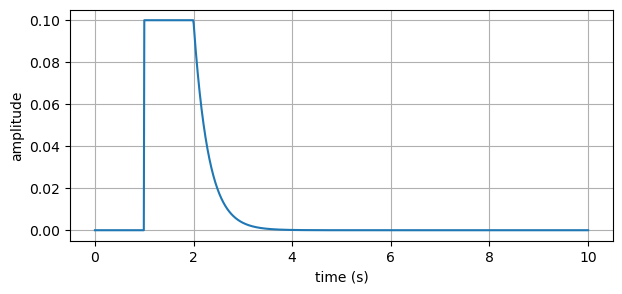

In [20]:
T = 10  # Seconds for the simulation
Init = 1  # First second to simulate
t = numpy.linspace(0,T,1000)

ΔPL = get_step(t, 1, -0.1)
ΔPvalve = get_step(t, 2, -0.1)

t, aux = control.forced_response(PM, t, ΔPvalve)
ΔP = aux - ΔPL
plot_control(ΔP, t)

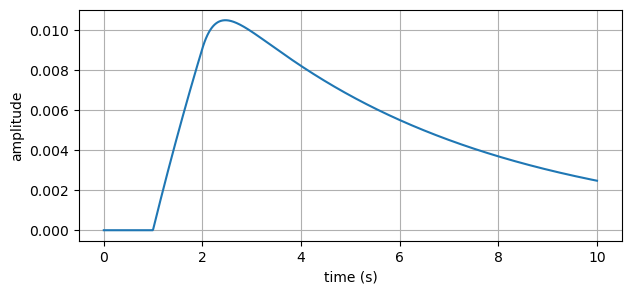

In [21]:
t, Δw = control.forced_response(Generator_Load, t, ΔP)
plot_control(Δw, t)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

### Generator, load, prime mover and droop model

Finally, we complete the model by adding the droop control:

![Generator_Load_PM_Droop_model.png](Figures/Generator_Load_PM_Droop_model.png)

In [22]:
T = 30  # Seconds for the simulation
t = numpy.linspace(0,T,1000)

R = 0.04
Tg = 1/20/R
Governor = control.tf(1, [Tg, 1])
print('Governor:')
Governor

Governor:


TransferFunction(array([1]), array([1.25, 1.  ]))

In [23]:
Tch = 0.3
Generator = control.tf(1, [Tch, 1])
print('Generator:')
Generator

Generator:


TransferFunction(array([1]), array([0.3, 1. ]))

In [24]:
M = 10
D = 2
Load = control.tf(1, [M, D])
print('Load:')
Load

Load:


TransferFunction(array([1]), array([10,  2]))

In [25]:
R_inv = control.tf(1, R)
print('1/R:')
R_inv

1/R:


TransferFunction(array([1]), array([0.04]))

Now taht we have all the components, the system can be solves as follows:

ΔP


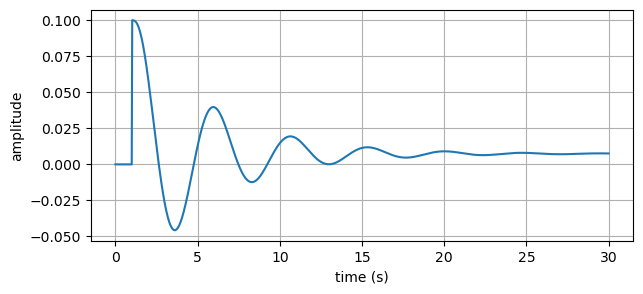

In [26]:
sys = control.feedback(Load, R_inv*Governor*Generator)
ΔPL = get_step(t, 1, 0.1)
t, Δw = control.forced_response(sys, t, ΔPL)

t, aux = control.forced_response(R_inv*Governor*Generator, t, Δw)
ΔP = ΔPL-aux
print('ΔP')
plot_control(ΔP, t)

Δw


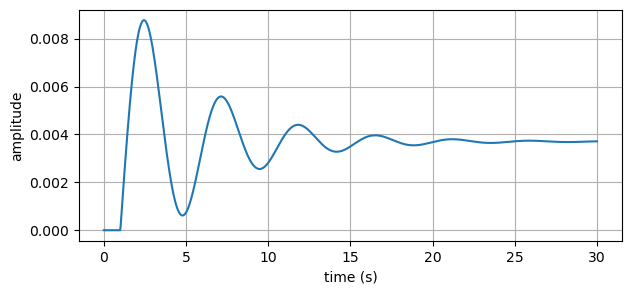

In [27]:
print('Δw')
plot_control(Δw, t)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)

### Coding the control model

For the sake of convenience, we can create a method with the full control model.

In [28]:
def get_control_model(R, D, M, Tch, Tg):
    Governor = control.tf(1, [Tg, 1])

    Generator = control.tf(1, [Tch, 1])

    Load = control.tf(1, [M, D])

    R_inv = control.tf(1, R)

    return control.feedback(Load, R_inv*Governor*Generator)
    
def control_model(ΔPL_value, R, D, M, Tch, Tg, T):
    import control
    TF = get_control_model(R, D, M, Tch, Tg)

    t = numpy.linspace(0, T, 1000)

    ΔPL = get_step(t, 1, ΔPL_value)

    t, Δw = control.forced_response(TF, t, ΔPL)

    return t, Δw

The control model can now be simulated as follows:

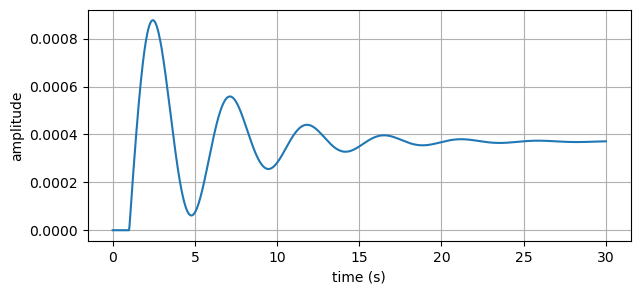

In [29]:
R = 0.04
D = 2
M = 10
Tch = 0.3
Tg = 1/20/R
T = 30
t, Δw = control_model(0.01, R, D, M, Tch, Tg, T)
plot_control(Δw, t)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-04---Frequency-regulation)